In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import pickle

import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [9]:
data = pd.read_csv('Lab.csv')

data.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [10]:
df = data.drop(['ID', 'No_Pation'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  1000 non-null   object 
 1   AGE     1000 non-null   int64  
 2   Urea    1000 non-null   float64
 3   Cr      1000 non-null   int64  
 4   HbA1c   1000 non-null   float64
 5   Chol    1000 non-null   float64
 6   TG      1000 non-null   float64
 7   HDL     1000 non-null   float64
 8   LDL     1000 non-null   float64
 9   VLDL    1000 non-null   float64
 10  BMI     1000 non-null   float64
 11  CLASS   1000 non-null   object 
dtypes: float64(8), int64(2), object(2)
memory usage: 93.9+ KB


# EDA

In [11]:
obj = df.select_dtypes(include=['object']).copy()

for i in obj.columns:
    print(obj[i].value_counts())

Gender
M    565
F    434
f      1
Name: count, dtype: int64
CLASS
Y     840
N     102
P      53
Y       4
N       1
Name: count, dtype: int64


In [12]:
df.describe()

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.528000,5.124743,68.943000,8.281160,4.862820,2.349610,1.204750,2.609790,1.854700,29.578020
std,8.799241,2.935165,59.984747,2.534003,1.301738,1.401176,0.660414,1.115102,3.663599,4.962388
min,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


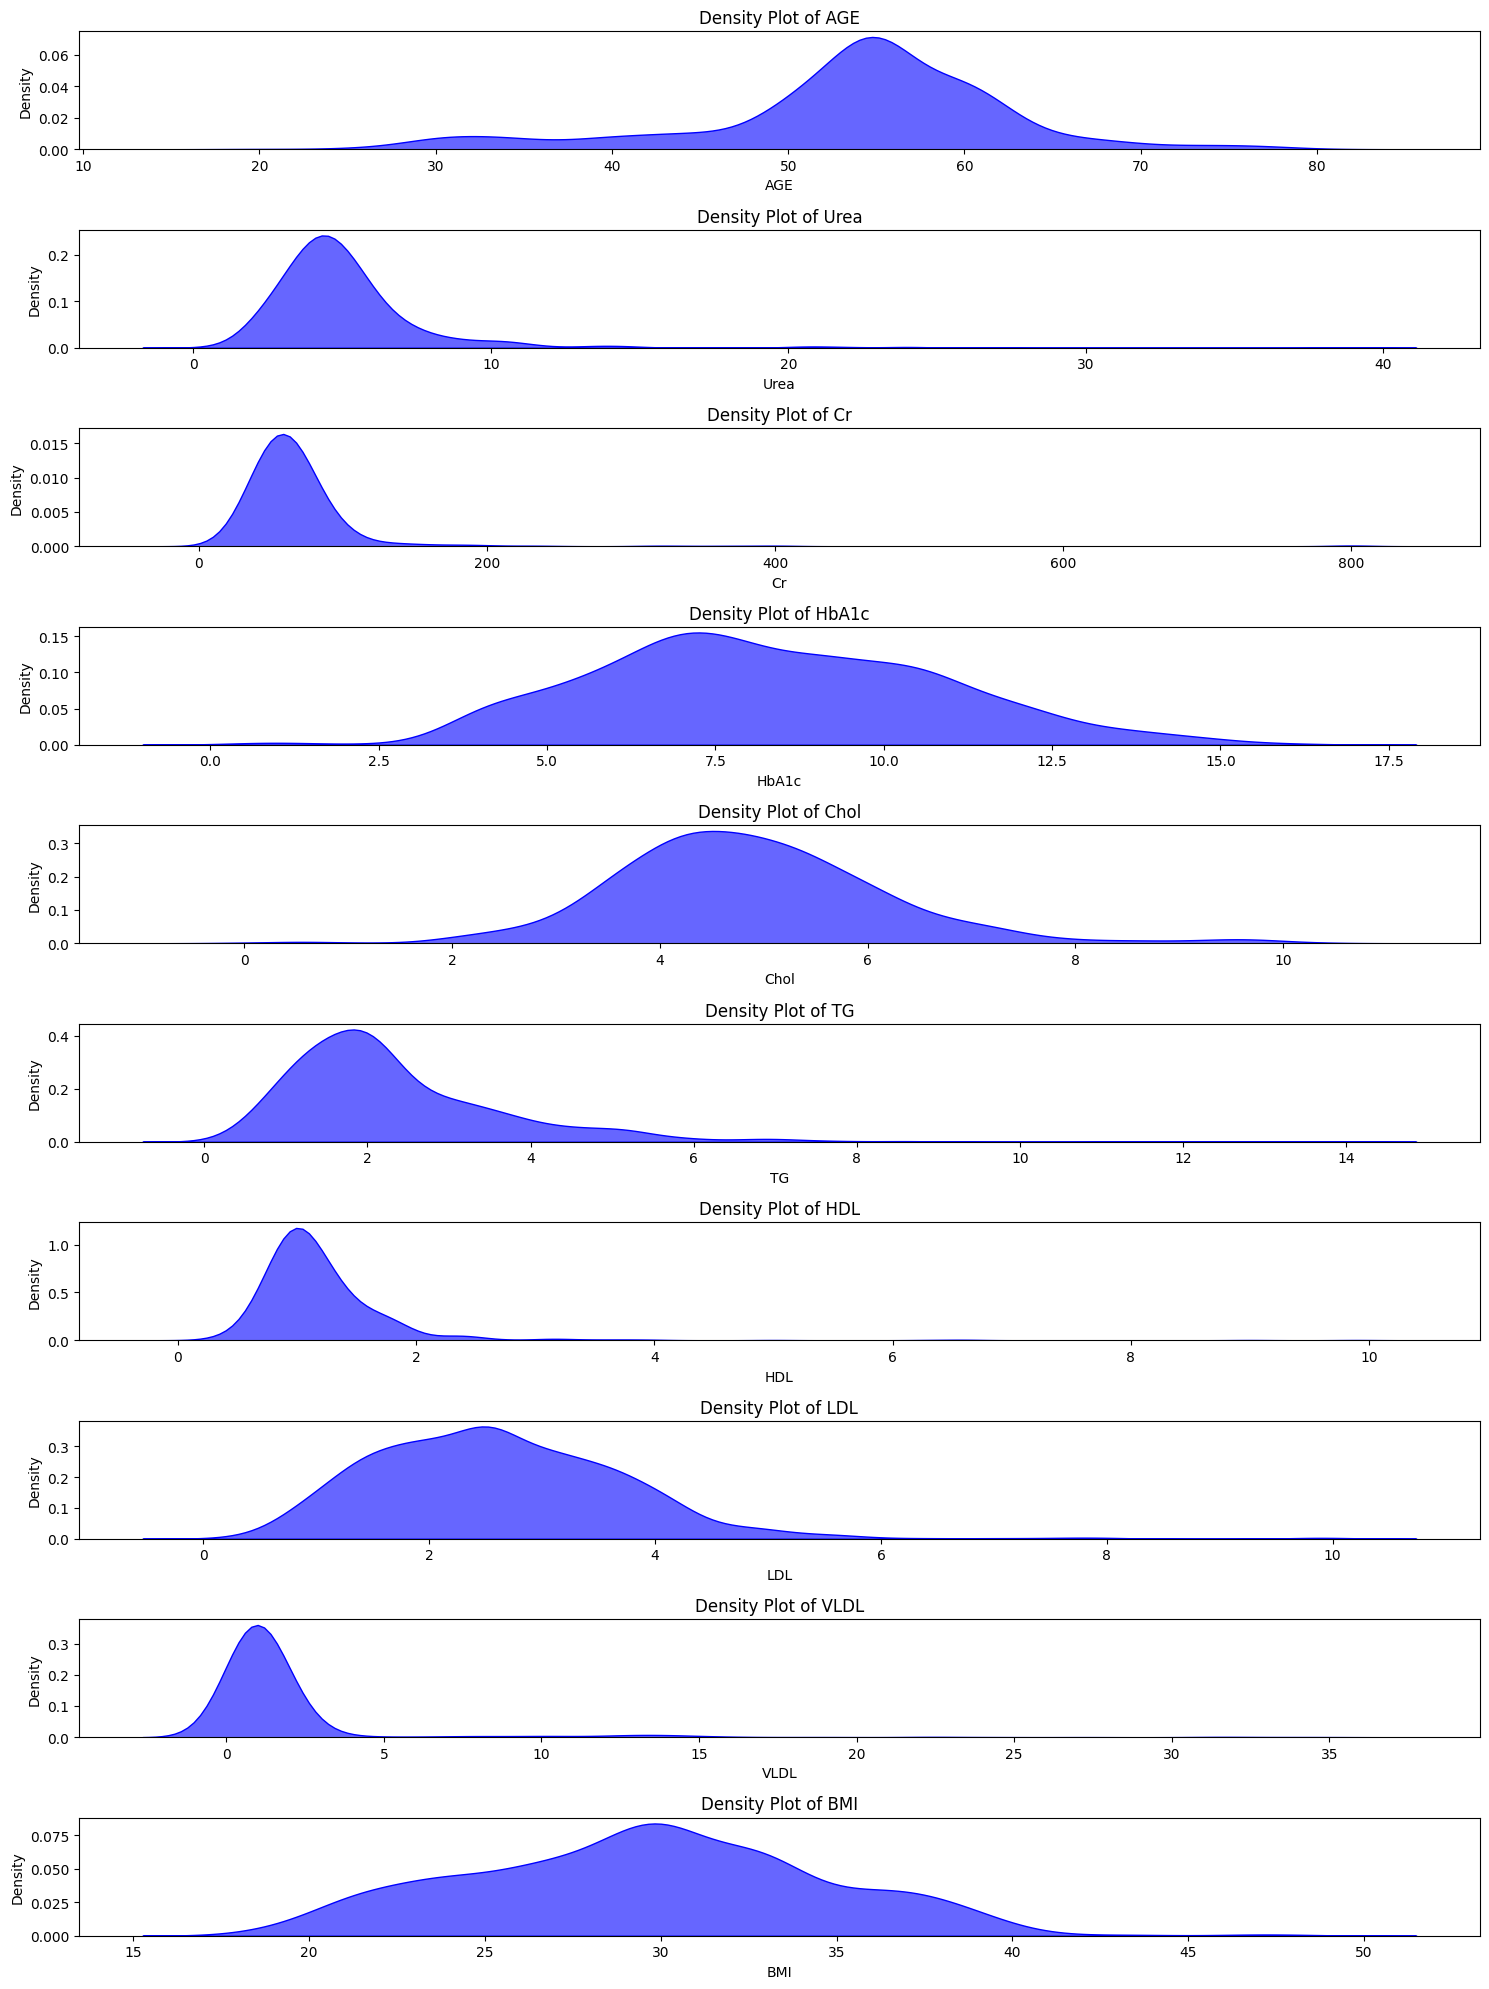

In [13]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Prepare the plots
plt.figure(figsize=(15, 20))

for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 1, i + 1)  # Create a subplot for each column
    sns.kdeplot(data=df, x=column, fill=True, alpha=0.6, color='blue')  # Density shading
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel(f'Density')  # Custom y-label reflecting the column name

plt.tight_layout()
plt.show()

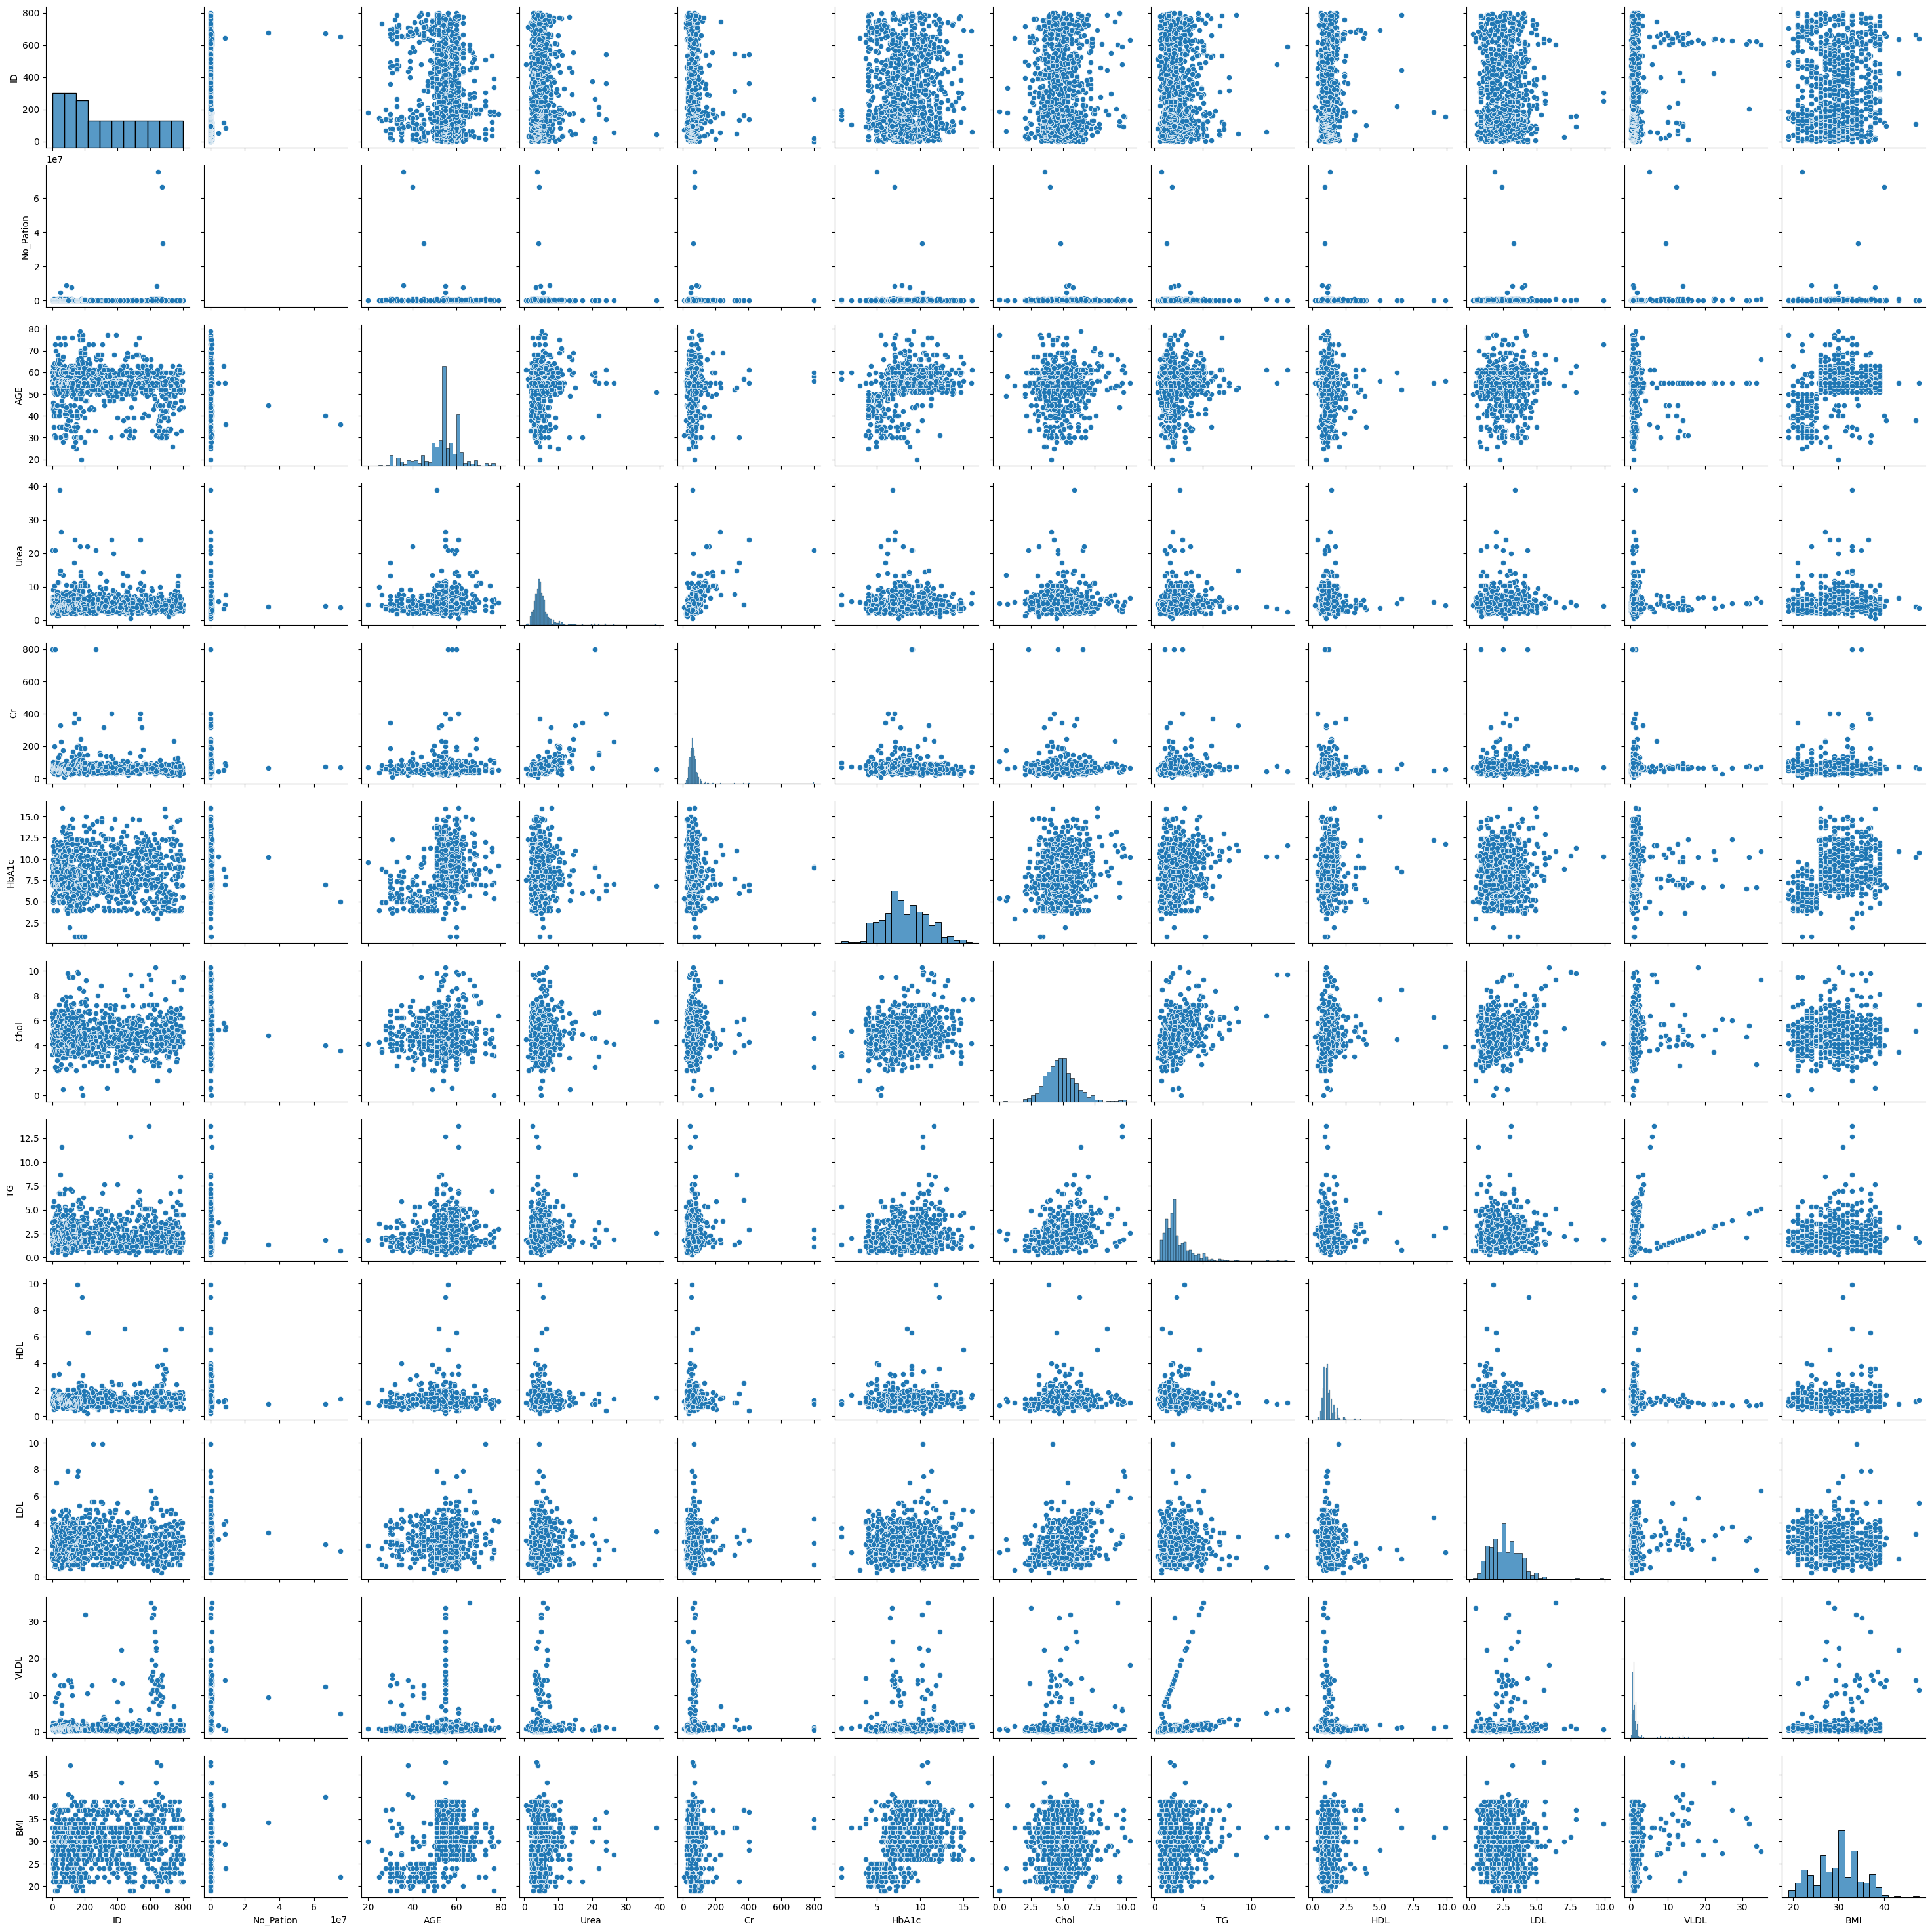

In [14]:
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Create pairwise scatter plots
sns.pairplot(data[numeric_columns])
plt.show()

# Encoding

In [15]:
def gender_cleaner(x):
    if x.lower() == 'f':
        return 1
    if x.lower() == 'm':
        return 0

def class_cleaner(x):
    if 'Y' in x:
        return 2
    elif 'N' in x:
        return 0
    else:
        return 1

# Apply the cleaning functions
df['Gender'] = df['Gender'].apply(gender_cleaner)
df['CLASS'] = df['CLASS'].apply(class_cleaner)

print(df['Gender'].value_counts())
print(df['CLASS'].value_counts())

Gender
0    565
1    435
Name: count, dtype: int64
CLASS
2    844
0    103
1     53
Name: count, dtype: int64


In [19]:
rus = RandomUnderSampler(random_state=42)
X = df.drop('CLASS', axis=1)
y = df['CLASS']

X_resampled, y_resampled = rus.fit_resample(X, y)

In [20]:
print(y_resampled.value_counts())

CLASS
0    53
1    53
2    53
Name: count, dtype: int64


# Baseline Model

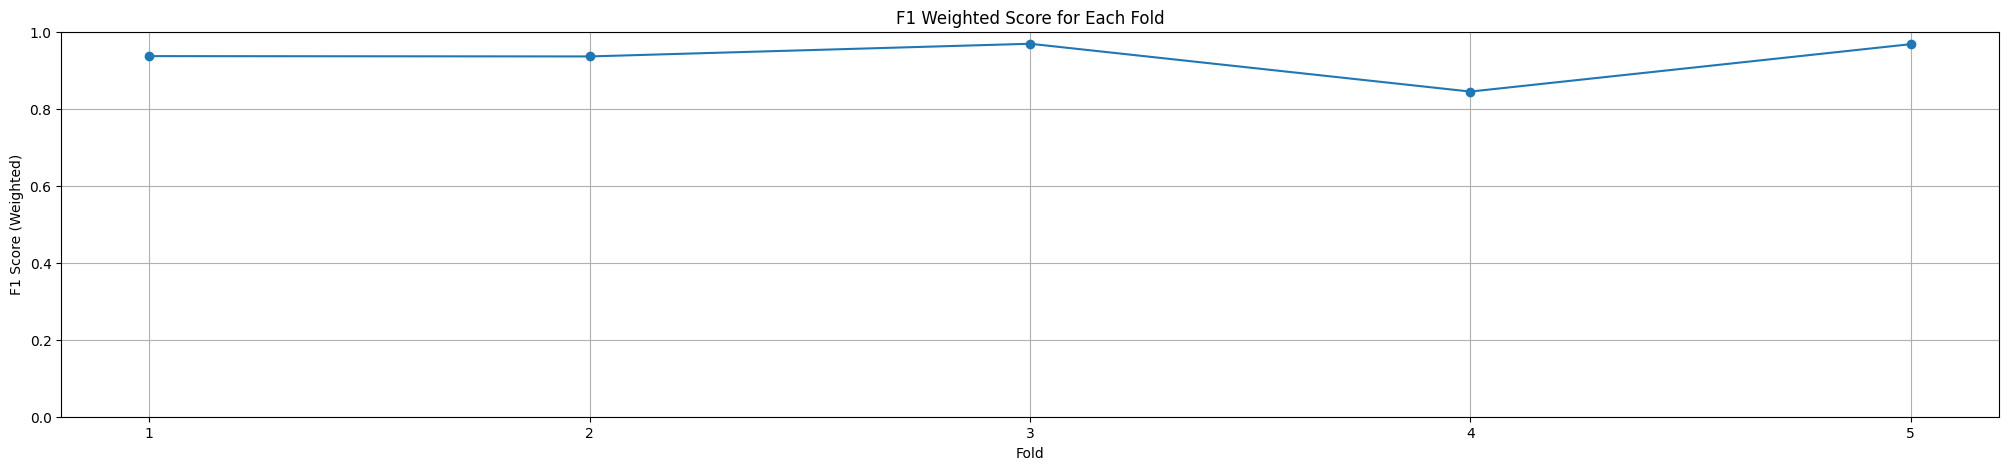

F1 Score: 0.9307 ± 0.0454


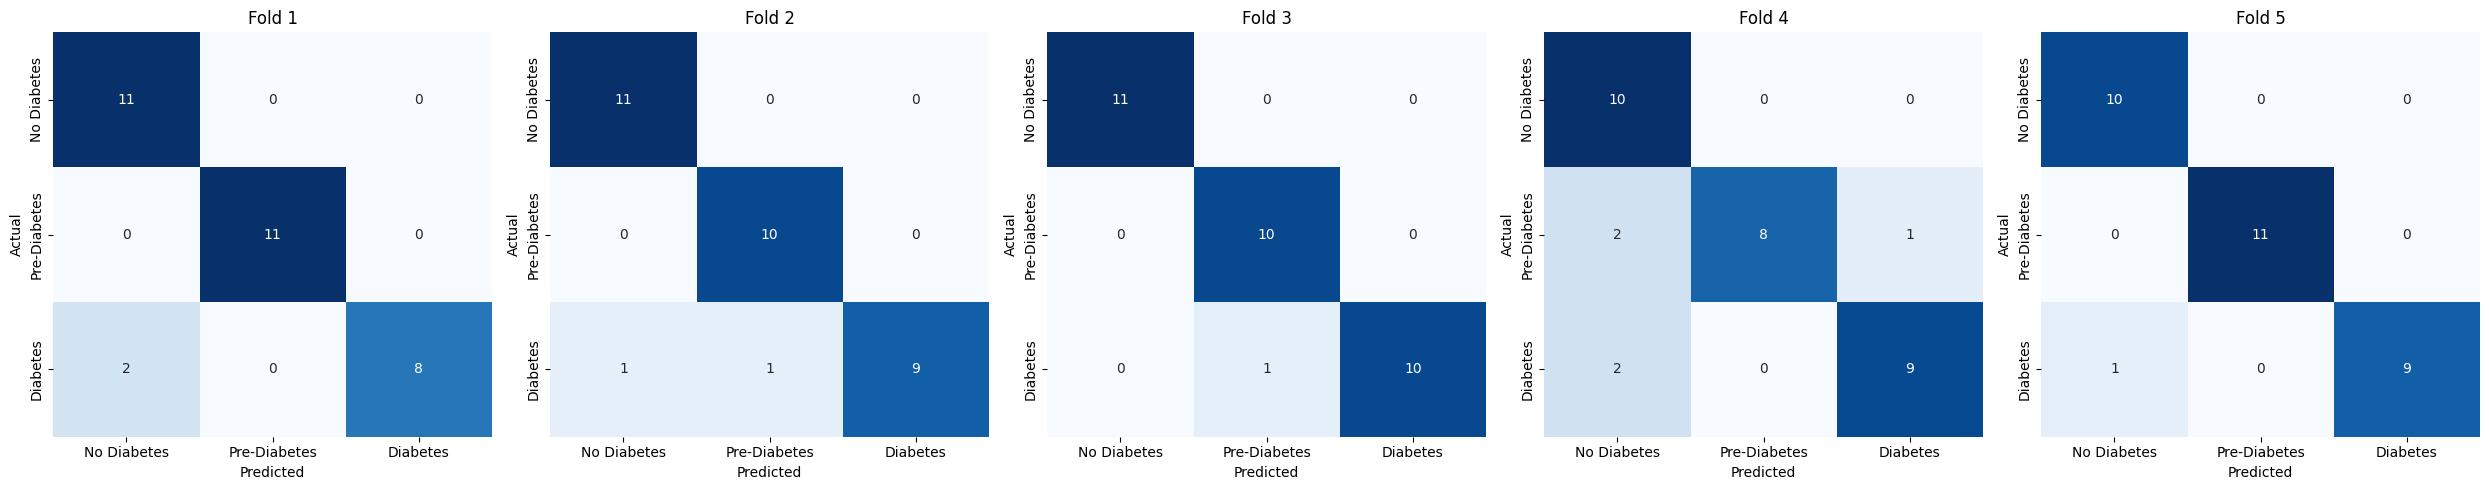

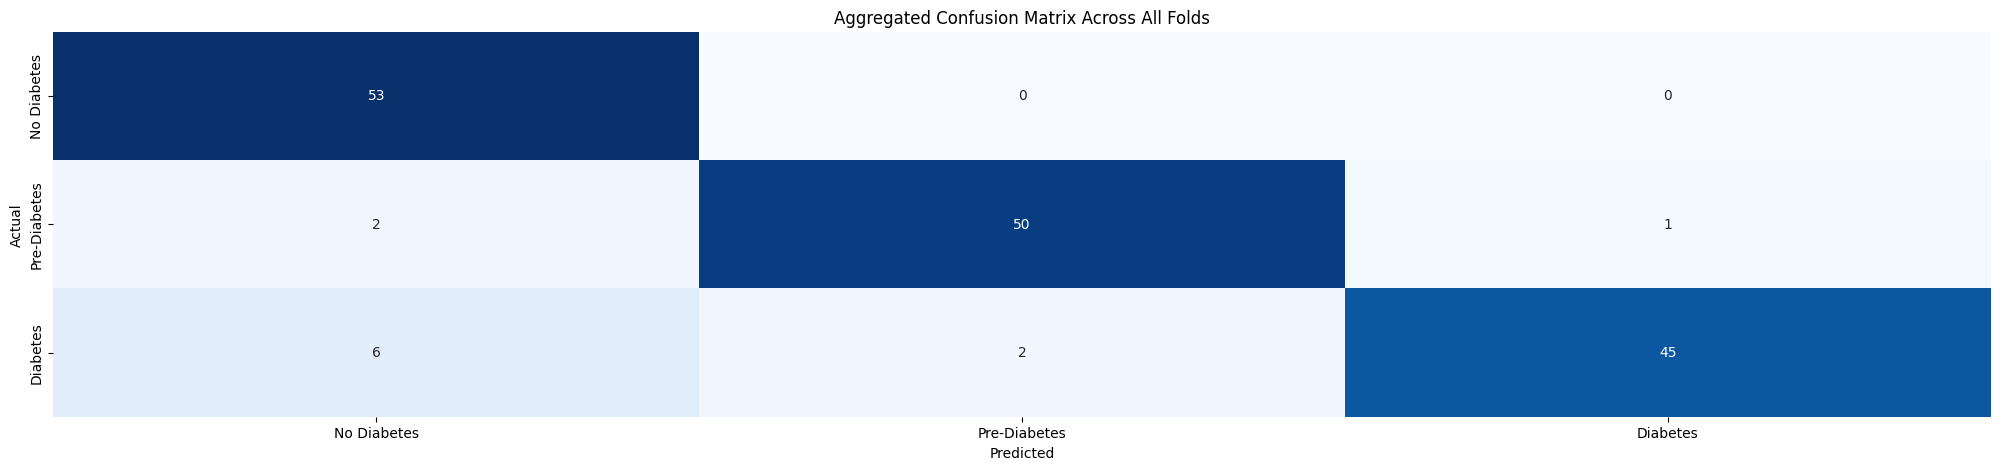

In [24]:
lgbm_model = lgb.LGBMClassifier(random_state=42, verbose=-1)

# Stratified K-Folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store F1 scores and confusion matrices
f1_scores = []
confusion_matrices = []

# Cross-validation
for train_index, test_index in kf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Visualize F1 scores
plt.figure(figsize=(25, 5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.title('F1 Weighted Score for Each Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score (Weighted)')
plt.xticks(range(1, len(f1_scores) + 1))
plt.ylim(0, 1)  # F1 score range from 0 to 1
plt.grid()
plt.show()
print(f'F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}')

# Display confusion matrices for each fold
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 1 row and 5 columns

for i, (ax, cm) in enumerate(zip(axes, confusion_matrices)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                ax=ax, 
                xticklabels=['No Diabetes','Pre-Diabetes' ,'Diabetes'], 
                yticklabels=['No Diabetes','Pre-Diabetes' ,'Diabetes'])
    ax.set_title(f'Fold {i + 1}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Aggregate confusion matrix
agg_cm = sum(confusion_matrices)

# Display aggregated confusion matrix
plt.figure(figsize=(25, 5))
sns.heatmap(agg_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Diabetes','Pre-Diabetes' ,'Diabetes'], 
            yticklabels=['No Diabetes','Pre-Diabetes' ,'Diabetes'])
plt.title('Aggregated Confusion Matrix Across All Folds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_7359/1661252247.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


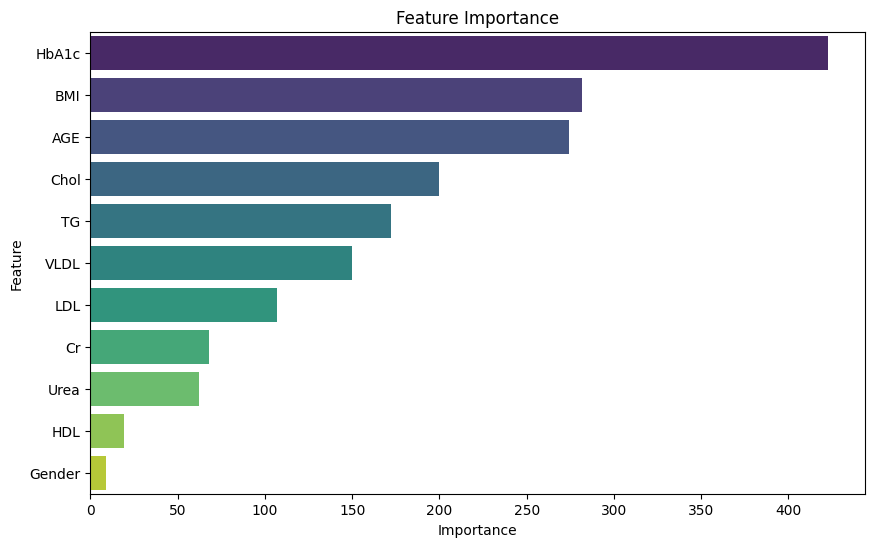

In [26]:
lgbm_model.fit(X_resampled, y_resampled)  # Fit the model to get feature importance
importance = lgbm_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X_resampled.columns, 'Importance': importance})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Model Selection

In [27]:
# Initialize models
models = {
    'LGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0),
    'CatBoost': cb.CatBoostClassifier(verbose=0, random_state=42)
}

# Stratified K-Folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store F1 scores for each model
results = {name: [] for name in models.keys()}

# Cross-validation
for train_index, test_index in kf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name].append(f1)

# Calculate average F1 scores
average_results = {name: np.mean(scores) for name, scores in results.items()}

# Display the average F1 scores
print("Average F1 Scores:")
for model_name, score in average_results.items():
    print(f"{model_name}: {score:.4f}")


Average F1 Scores:
LGBM: 0.9307
XGBoost: 0.9556
CatBoost: 0.9684


# Final Model

Mean F1 Score across folds: 0.9306749272228023


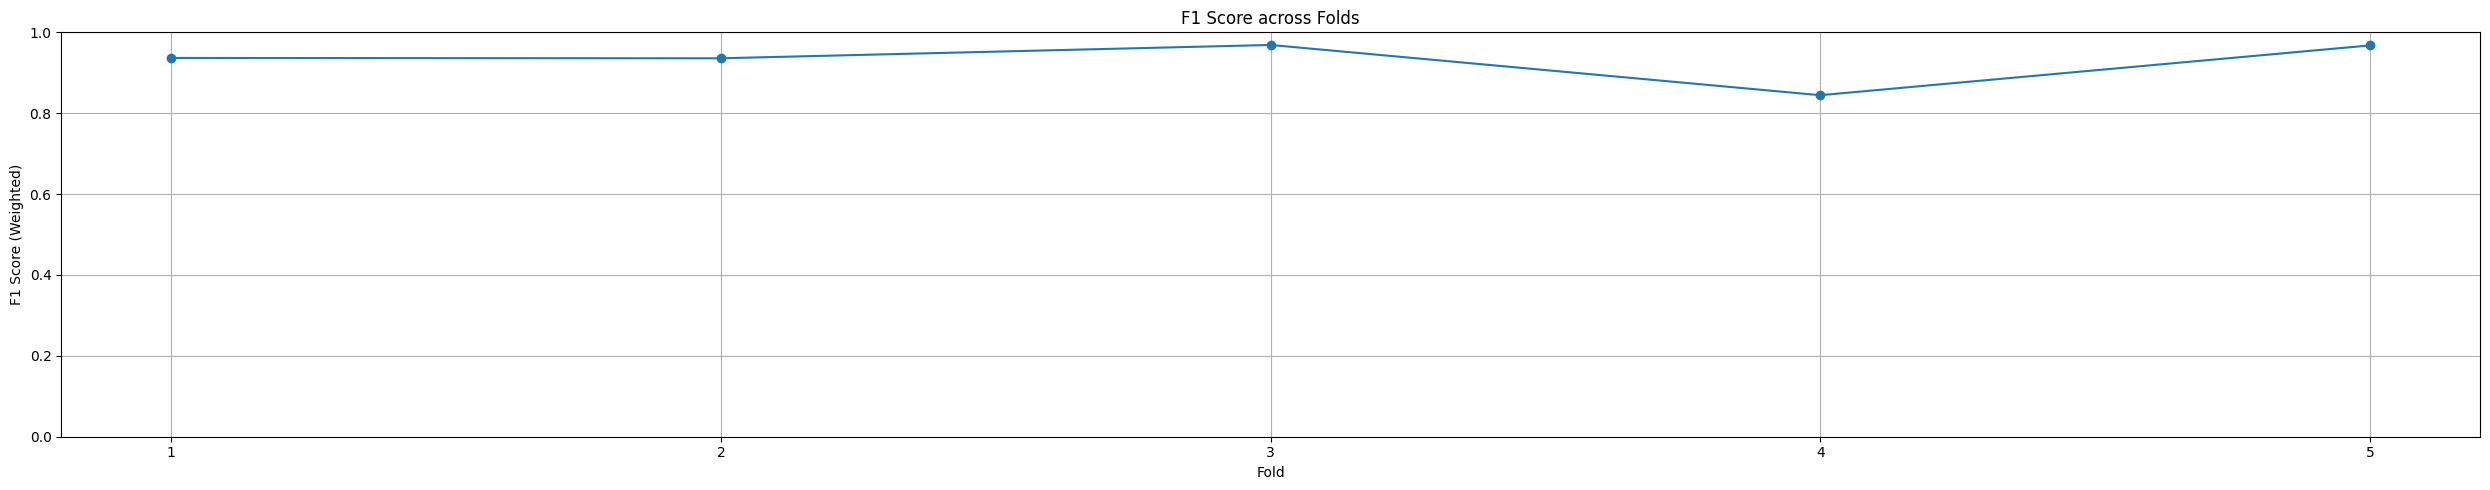

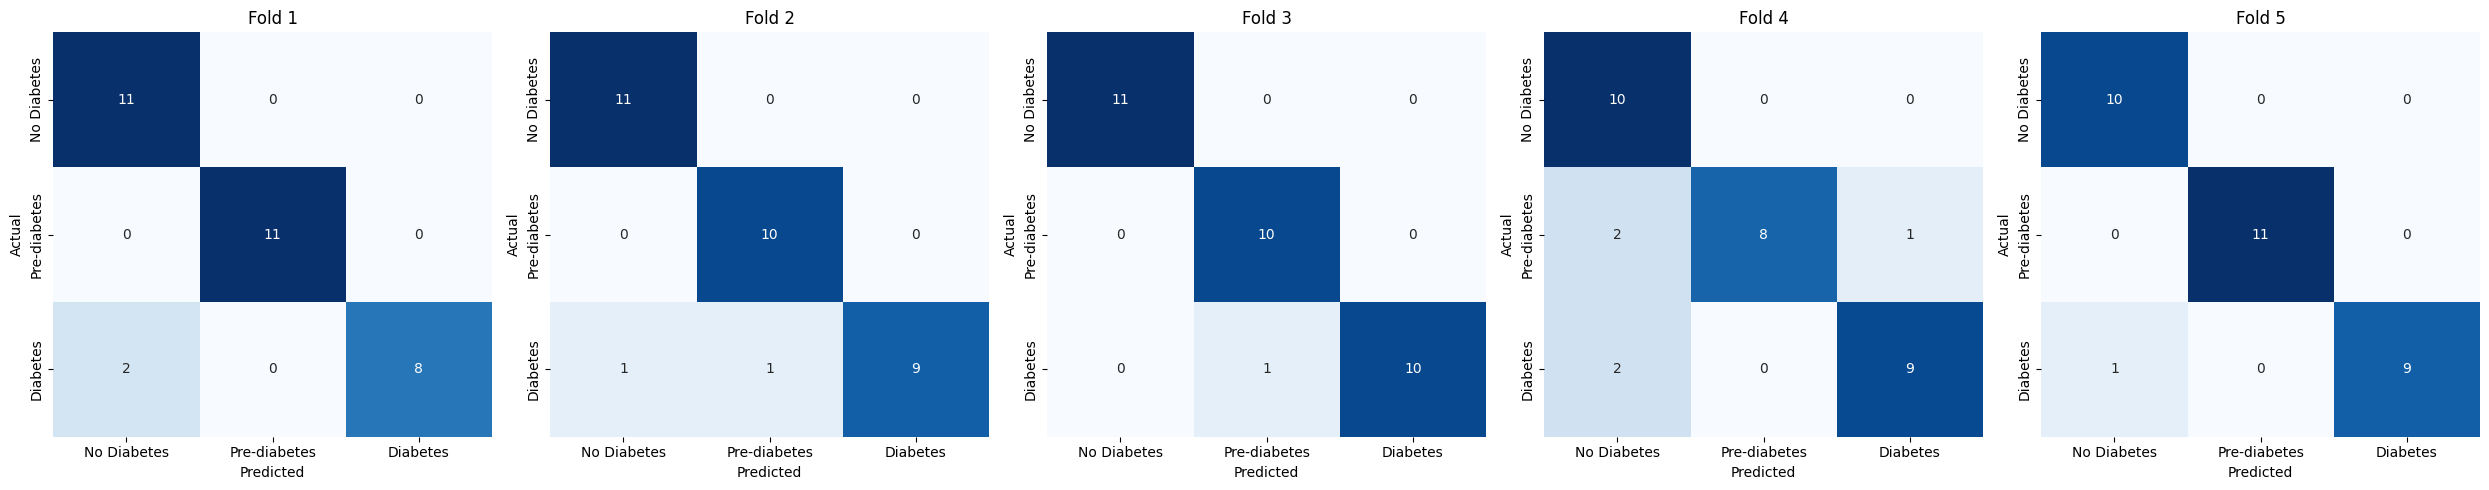

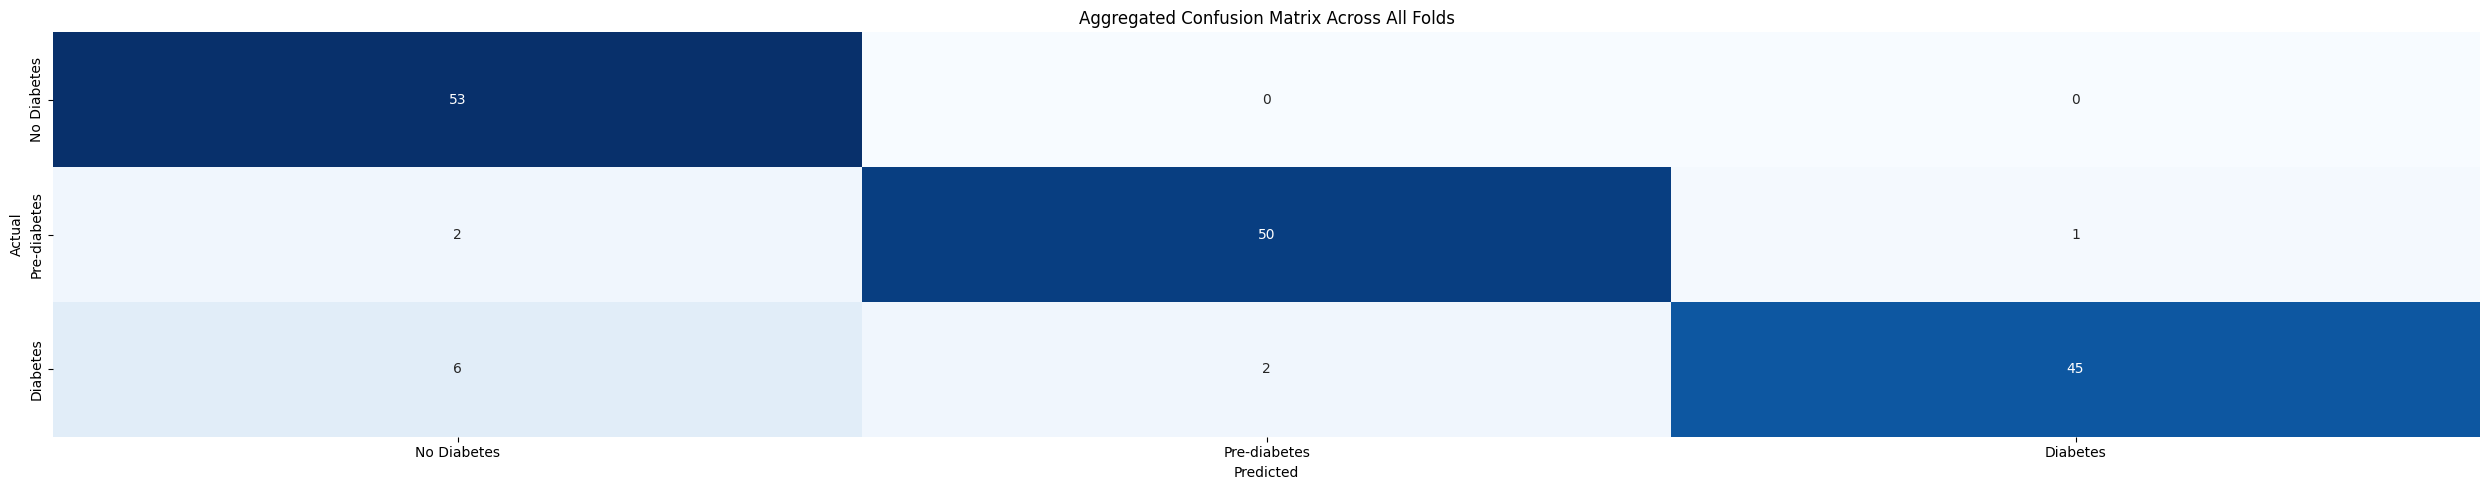

In [30]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
f1_scores = []
confusion_matrices = []

# Cross-validation with the best model
for train_index, test_index in kf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

    model = lgb.LGBMClassifier(random_state=42, verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Print mean F1 score
mean_f1 = np.mean(f1_scores)
print("Mean F1 Score across folds:", mean_f1)

# Visualize F1 scores
plt.figure(figsize=(25, 5))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.title('F1 Score across Folds')
plt.xlabel('Fold')
plt.ylabel('F1 Score (Weighted)')
plt.xticks(range(1, len(f1_scores) + 1))
plt.ylim(0, 1)  # F1 score range from 0 to 1
plt.grid()
plt.tight_layout()
plt.show()

# Display confusion matrices for each fold in a 1x5 grid
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, (ax, cm) in enumerate(zip(axes, confusion_matrices)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                ax=ax,
                xticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'], 
                yticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'])
    ax.set_title(f'Fold {i + 1}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Aggregate confusion matrix
agg_cm = sum(confusion_matrices)

# Display aggregated confusion matrix
plt.figure(figsize=(25, 5))
sns.heatmap(agg_cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'], 
            yticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.title('Aggregated Confusion Matrix Across All Folds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [32]:
model = lgb.LGBMClassifier(random_state=42, verbose=-1)
model.fit(X_resampled, y_resampled)

with open('model_lgb.pkl', 'wb') as file:
    pickle.dump(model, file)

In [33]:
data = {
    'Gender': ['Male', 'Female', 'Male'],
    'AGE': [30, 50, 55],
    'Urea': [25, 28, 40],
    'Cr': [1.0, 1.1, 1.5],
    'HbA1c': [5.2, 6.0, 7.5],
    'Chol': [180, 200, 250],
    'TG': [90, 120, 180],
    'HDL': [60, 50, 40],
    'LDL': [100, 120, 140],
    'VLDL': [20, 24, 35],
    'BMI': [21, 25, 28],
}

test = pd.DataFrame(data)
test['Gender'] = test['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

test['Prediction'] = model.predict(test)

In [35]:
test

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Prediction
0,0,30,25,1.0,5.2,180,90,60,100,20,21,No Diabetes
1,1,50,28,1.1,6.0,200,120,50,120,24,25,Pre-Diabetes
2,0,55,40,1.5,7.5,250,180,40,140,35,28,Diabetes
